**Name**: Diran Suraj

**PI**: Z7279378

# TM358 TMA 02 Question 1

# Introduction to TMA02

You should be able to work on this TMA when you have completed Block 2 and Block 3 of the module. This TMA will be focused on completing a sentiment analysis task using two types of deep neural network, namely RNN (Block 3) and CNN (Block 2) and compare the results. 
The [Amazon review dataset](https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews) is used in this TMA for sentiment analysis. The pre-processed dataset can be found in the directory /datasets/amazon-reviews/, divided into training, validation and test sets. The dataset has been adapted so that there is a rating of 0=negative and 1=positive for each review document.

# Question 1 (33 marks)

By completing Question 1, you will have shown your understanding of the following learning outcomes: 

* The application of LSTM models for sentiment analysis.
* Investigate and evaluate different hyperparameters for creating and training models.
* Present the evaluation of the models.

You should look at the notebooks for Block 3 while working through this question. You will find many useful examples in those notebooks which will help you in this assignment.

In this notebook, example code for loading the data and building LSTM has been provided. Then you will start working on the sub-questions. Record all your activity and observations in this notebook. Insert additional notebook cells as required. 


Include Markdown cells liberally in your solutions, to describe what you are doing. This will help your tutor give full credit for all you have done, and is invaluable in reminding you what you were doing when you return to the TMA after a few days away.

See the VLE for details of how to submit your completed notebook. You should submit only this notebook file for this question.

## Important note about training and saving the model

Ensure that the code cell where you train the model also includes saving of the model and training history. This is a large dataset and models will take some time to train. You can leave the model to train while you do something else (ensure your PC does not go to sleep). 

Once training is finished and the container is idle, it will shut down after a while. If you save the model as soon as it has finished training (in the same notebook cell), you can load the model on your return. If you don't save the model, you will lose that work. 

Below is an example of how to do this.

## Marks are based on process, not results

In this notebook, you will be asked to create, train, and evaluate several neural networks. Training neural networks is inherently a stochastic process, based on the random allocation of initial weights and the shuffled order of training examples. Therefore, your results will differ from results generated by other students, and those generated by the module team and presented in the tutor's marking guide.

The marks in this question are awarded solely on your ability to carry out the steps of training and evaluation, not on any particular results you may achieve. **There are no thresholds for accuracy (or any other metric) you must achieve.** You will gain credit for carrying out the tasks specified in this question, including honest evaluations of how the models perform. 

## Taking a section of the training dataset

As the dataset is very large, it can take a long time to train a model. Instead, you will use and compare several reduced sizes of the dataset used for training in this TMA. 

The `shard` operation takes a fraction of the dataset. `shard(n, k)` will split the dataset into `n` fragments and keep just the `k`th one (indexed from zero). For instance, `shard(10, 0)` will split the dataset into ten pieces and keep just the zeroth one (i.e. take a tenth of the data); `shard(2, 0)` will split the dataset into two pieces and keep the zeroth one (i.e. take half the data). 

In this notebook, four versions of the training data are loaded, each representing a different fraction of the full training data.

## Importing the required libraries

In [1]:
import numpy as np
import tensorflow as tf
import json

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
%matplotlib inline

## Creating some constants

In [2]:
BATCH_SIZE = 512

In [3]:
METRICS = [
      lambda : tf.keras.metrics.TruePositives(name='tp'),
      lambda : tf.keras.metrics.FalsePositives(name='fp'),
      lambda : tf.keras.metrics.TrueNegatives(name='tn'),
      lambda : tf.keras.metrics.FalseNegatives(name='fn'), 

      lambda : tf.keras.metrics.Accuracy(name='accuracy'),
      lambda : tf.keras.metrics.Precision(name='precision'),
      lambda : tf.keras.metrics.Recall(name='recall'),
]

def fresh_metrics():
    return [metric() for metric in METRICS]

## Loading the data

In [4]:
train_filename = '/datasets/amazon-reviews/train.csv'
val_filename = '/datasets/amazon-reviews/validation.csv'
test_filename = '/datasets/amazon-reviews/test.csv'

In [5]:
train_data = tf.data.experimental.make_csv_dataset(train_filename, batch_size=BATCH_SIZE, num_epochs=1)
train_data = train_data.map(lambda d: (d['Review'], d['Rating']))

In [6]:
# take 10% of the training data
train_data10 = train_data.shard(10, 0)

train_data10 = train_data10.cache()
train_data10 = train_data10.shuffle(50000)
train_data10 = train_data10.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [7]:
# take 25% of the training data
train_data25 = train_data.shard(4, 0)

train_data25 = train_data25.cache()
train_data25 = train_data25.shuffle(50000)
train_data25 = train_data25.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [8]:
# take 50% of the training data
train_data50 = train_data.shard(2, 0)

train_data50 = train_data50.cache()
train_data50 = train_data50.shuffle(50000)
train_data50 = train_data50.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [9]:
# use all the training data
train_data = train_data.cache()
train_data = train_data.shuffle(50000)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [10]:
validation_data = tf.data.experimental.make_csv_dataset(val_filename, batch_size=BATCH_SIZE, num_epochs=1)
validation_data = validation_data.map(lambda d: (d['Review'], d['Rating']))
validation_data = validation_data.cache()
validation_data = validation_data.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [11]:
test_data = tf.data.experimental.make_csv_dataset(test_filename, batch_size=BATCH_SIZE, num_epochs=1)
test_data = test_data.map(lambda d: (d['Review'], d['Rating']))
test_data = test_data.cache()
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

## Creating text encoders

The following code creates and saves text encoders for different vocabulary sizes (100, 200 and 300 in this TMA). Running this code will take some time, but this saves the files for use later.

After your first run of this notebook, comment out the cells that adapt and save the encoders.

In [12]:
!mkdir encoder100
!mkdir encoder200
!mkdir encoder300

### Create, adapt, and save an encoder

You will only need to do this once. You may like to comment out the code in these cells after the first run.

In [13]:
encoder = tf.keras.layers.TextVectorization(max_tokens=100)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder100')

In [14]:
encoder = tf.keras.layers.TextVectorization(max_tokens=200)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder200')

In [15]:
encoder = tf.keras.layers.TextVectorization(max_tokens=300)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder300')

### Create an encoder and load its assets from file

In [16]:
encoder100 = tf.keras.layers.TextVectorization(max_tokens=100)
encoder100.load_assets('encoder100')

In [17]:
encoder200 = tf.keras.layers.TextVectorization(max_tokens=200)
encoder200.load_assets('encoder200')

In [18]:
encoder300 = tf.keras.layers.TextVectorization(max_tokens=300)
encoder300.load_assets('encoder300')

## An Example LSTM model

The following is an example LSTM model to help you start with. The model uses word embedding length of 16, vocabulary size of 100 words, 1 LSTM unit and a dense layer (with 1 node and a sigmoid activation). Train the model over 5 epochs with 10% of the training dataset, using binary_crossentropy as loss, adam as optimizer, and acuracy as metric.

### Build the model

In [20]:
EMBEDDING_LEN = 16  # The length of the word embedding vector
example_model = Sequential([
    encoder100, # using 100-word encoder
    Embedding(input_dim=len(encoder100.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    LSTM(1), # using 1 LSTM units
    Dense(1, activation='sigmoid') # dense layer  with 1 node and a sigmoid activation
])

### Train the model over 5 epochs with 10% of the training dataset. Save the trained model and the training history
Note that training LSTM models can take some time. So please be patient. Once you have trained and saved the model, you can load it directly from the saved file when you use it next time.

In [21]:
# Compile the model
example_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model with 10% of the training data for 5 epochs
example_history = example_model.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1)

# Save the model and training records
example_model.save('example_review.keras')
with open('example_review_history.json', 'w') as f:
    json.dump(example_history.history, f)
    

Epoch 1/5
    704/Unknown 287s 354ms/step - accuracy: 0.5988 - loss: 0.6578

/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


704/704 ━━━━━━━━━━━━━━━━━━━━ 302s 375ms/step - accuracy: 0.5989 - loss: 0.6578 - val_accuracy: 0.7117 - val_loss: 0.5584
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 267s 379ms/step - accuracy: 0.7127 - loss: 0.5603 - val_accuracy: 0.7167 - val_loss: 0.5506
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 240s 341ms/step - accuracy: 0.7158 - loss: 0.5547 - val_accuracy: 0.7177 - val_loss: 0.5486
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 220s 313ms/step - accuracy: 0.7167 - loss: 0.5532 - val_accuracy: 0.7178 - val_loss: 0.5471
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 220s 312ms/step - accuracy: 0.7165 - loss: 0.5520 - val_accuracy: 0.7131 - val_loss: 0.5505


### Reload the trained model and training history

In [22]:
example_model = tf.keras.models.load_model('example_review.keras')
with open('example_review_history.json') as f:
    example_history = json.load(f)
    
example_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_3            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 16)       │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,024 (19.63 KB)

 Trainable params: 1,674 (6.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,350 (13.09 KB)

### Plot the training history

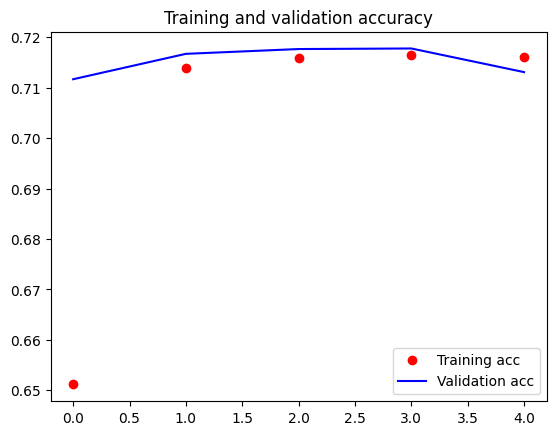

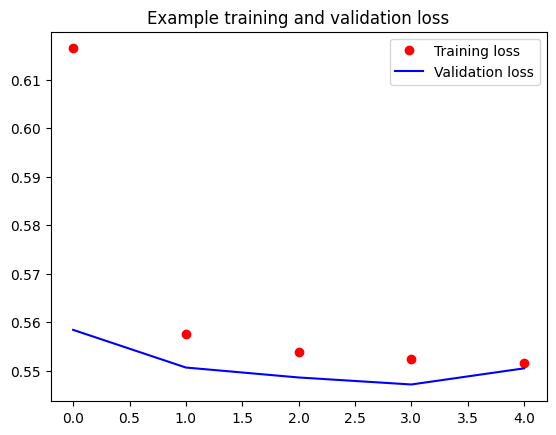

In [23]:
acc = example_history['accuracy']
val_acc = example_history['val_accuracy']
loss = example_history['loss']
val_loss = example_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Example training and validation loss')
plt.legend()

plt.show()

### Evaluate the model with the test data

In [24]:
example_model_results = example_model.evaluate(test_data, return_dict=True)
example_model_results

625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - accuracy: 0.7109 - loss: 0.5581


{'accuracy': 0.7121968865394592, 'loss': 0.5557378530502319}

# You are now ready to attempt TMA02 Question 1

# Q1a - 9 marks: Create and train the following LSTM models

### The first part your investigation is to train various LSTM models with varying size of vobabulary and  length of word embedding vectors.

For your models you should:

* use 10% of the training data
* train for 5 epochs, using binary_crossentropy as loss, adam as optimizer, and acuracy as metric

(1) Create the following three LSTM models, which involve 4 LSTM units with varying word embedding length and vocabulary size, followed by a dense layer with 1 node and a sigmoid activation for final classification. (6 marks)

* LSTM_model_1: with 4 LSTM units, using 200-word encoder, word embedding length of 16 
* LSTM_model_2: with 4 LSTM units, using 300-word encoder, word embedding length of 16
* LSTM_model_3: with 4 LSTM units, using 300-word encoder, word embedding length of 32 


(2) Train the above models. (3 marks)

* print a summary of each model's structure and parameters
* produce training and validation graphs for the models


## Build and train the required LSTM models

### Part (1)

In [49]:
EMBEDDING_LEN = 16  # The length of the word embedding vector
LSTM_model_1 = Sequential([
    encoder200, # using 200-word encoder
    Embedding(input_dim=len(encoder200.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    LSTM(4), # using 4 LSTM units
    Dense(1, activation='sigmoid') # dense layer with 1 node and a sigmoid activation
])

In [50]:
EMBEDDING_LEN = 16  # The length of the word embedding vector
LSTM_model_2 = Sequential([
    encoder300, # using 300-word encoder
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    LSTM(4), # using 4 LSTM units
    Dense(1, activation='sigmoid') # dense layer with 1 node and a sigmoid activation
])

In [51]:
EMBEDDING_LEN = 32  # The length of the word embedding vector
LSTM_model_3 = Sequential([
    encoder300, # using 300-word encoder
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    LSTM(4), # using 4 LSTM units
    Dense(1, activation='sigmoid') # dense layer with 1 node and a sigmoid activation
])

### Part (2)

#### LSTM_model_1

In [53]:
# Compile the model
LSTM_model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model with 10% of the training data for 5 epochs
LSTM_model_1_history = LSTM_model_1.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1)

# Save the model and training records
LSTM_model_1.save('LSTM_model_1_review.keras')
with open('LSTM_model_1_review_history.json', 'w') as f:
    json.dump(LSTM_model_1_history.history, f)
    

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 214s 301ms/step - accuracy: 0.7656 - loss: 0.4874 - val_accuracy: 0.7706 - val_loss: 0.4751
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 211s 300ms/step - accuracy: 0.7739 - loss: 0.4742 - val_accuracy: 0.7815 - val_loss: 0.4562
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 212s 301ms/step - accuracy: 0.7850 - loss: 0.4562 - val_accuracy: 0.7891 - val_loss: 0.4437
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 211s 300ms/step - accuracy: 0.7923 - loss: 0.4438 - val_accuracy: 0.7935 - val_loss: 0.4350
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 211s 300ms/step - accuracy: 0.7961 - loss: 0.4360 - val_accuracy: 0.7972 - val_loss: 0.4304


In [54]:
LSTM_model_1 = tf.keras.models.load_model('LSTM_model_1_review.keras')
with open('LSTM_model_1_review_history.json') as f:
    LSTM_model_1_history = json.load(f)
    
LSTM_model_1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_4            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, None, 16)       │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,625 (41.51 KB)

 Trainable params: 3,541 (13.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,084 (27.68 KB)

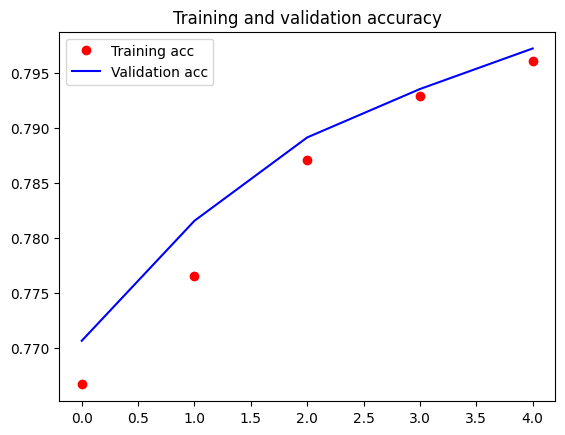

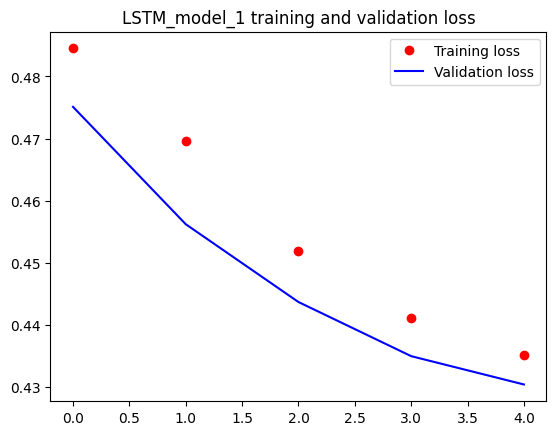

In [55]:
acc = LSTM_model_1_history['accuracy']
val_acc = LSTM_model_1_history['val_accuracy']
loss = LSTM_model_1_history['loss']
val_loss = LSTM_model_1_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('LSTM_model_1 training and validation loss')
plt.legend()

plt.show()

#### LSTM_model_2

In [56]:
# Compile the model
LSTM_model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model with 10% of the training data for 5 epochs
LSTM_model_2_history = LSTM_model_2.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1)

# Save the model and training records
LSTM_model_2.save('LSTM_model_2_review.keras')
with open('LSTM_model_2_review_history.json', 'w') as f:
    json.dump(LSTM_model_2_history.history, f)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 217s 305ms/step - accuracy: 0.7014 - loss: 0.5969 - val_accuracy: 0.7792 - val_loss: 0.4743
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 214s 304ms/step - accuracy: 0.7827 - loss: 0.4664 - val_accuracy: 0.7906 - val_loss: 0.4444
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 214s 305ms/step - accuracy: 0.7927 - loss: 0.4442 - val_accuracy: 0.7952 - val_loss: 0.4369
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 215s 305ms/step - accuracy: 0.7982 - loss: 0.4341 - val_accuracy: 0.7980 - val_loss: 0.4300
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 215s 305ms/step - accuracy: 0.8013 - loss: 0.4269 - val_accuracy: 0.7984 - val_loss: 0.4258


In [57]:
LSTM_model_2 = tf.keras.models.load_model('LSTM_model_2_review.keras')
with open('LSTM_model_2_review_history.json') as f:
    LSTM_model_2_history = json.load(f)
    
LSTM_model_2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_5            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, None, 16)       │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,425 (60.26 KB)

 Trainable params: 5,141 (20.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,284 (40.18 KB)

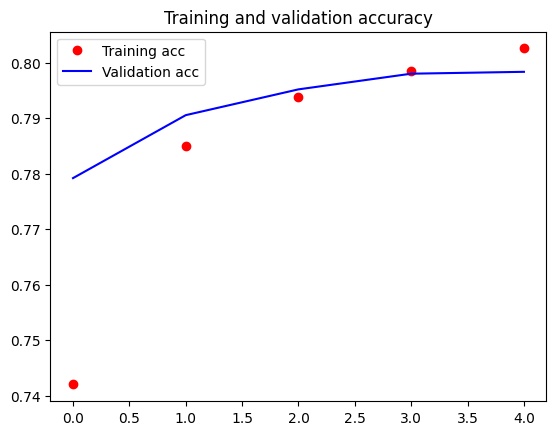

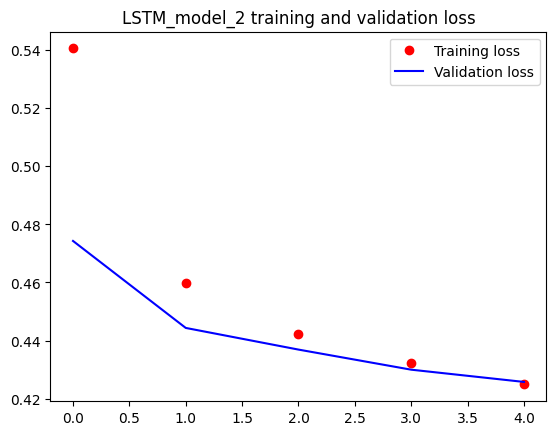

In [58]:
acc = LSTM_model_2_history['accuracy']
val_acc = LSTM_model_2_history['val_accuracy']
loss = LSTM_model_2_history['loss']
val_loss = LSTM_model_2_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('LSTM_model_2 training and validation loss')
plt.legend()

plt.show()

#### LSTM_model_3

In [60]:
# Compile the model
LSTM_model_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model with 10% of the training data for 5 epochs
LSTM_model_3_history = LSTM_model_3.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1)

# Save the model and training records
LSTM_model_3.save('LSTM_model_3_review.keras')
with open('LSTM_model_3_review_history.json', 'w') as f:
    json.dump(LSTM_model_3_history.history, f)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 215s 302ms/step - accuracy: 0.6918 - loss: 0.5905 - val_accuracy: 0.7847 - val_loss: 0.4592
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 213s 303ms/step - accuracy: 0.7880 - loss: 0.4541 - val_accuracy: 0.7972 - val_loss: 0.4345
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 212s 302ms/step - accuracy: 0.7965 - loss: 0.4366 - val_accuracy: 0.8016 - val_loss: 0.4240
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 212s 302ms/step - accuracy: 0.8024 - loss: 0.4252 - val_accuracy: 0.8084 - val_loss: 0.4130
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 212s 302ms/step - accuracy: 0.8090 - loss: 0.4141 - val_accuracy: 0.8146 - val_loss: 0.4019


In [61]:
LSTM_model_3 = tf.keras.models.load_model('LSTM_model_3_review.keras')
with open('LSTM_model_3_review_history.json') as f:
    LSTM_model_3_history = json.load(f)
    
LSTM_model_3.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_5            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, None, 32)       │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 4)              │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,593 (119.51 KB)

 Trainable params: 10,197 (39.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,396 (79.68 KB)

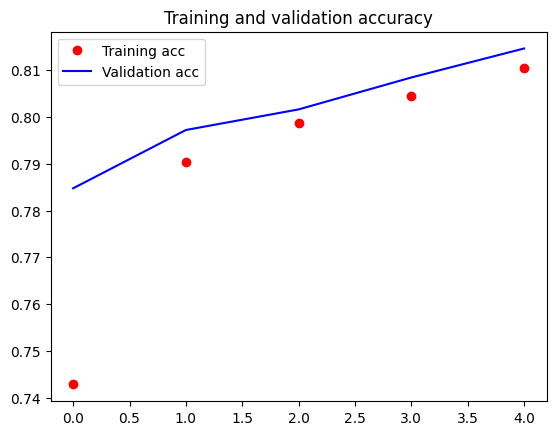

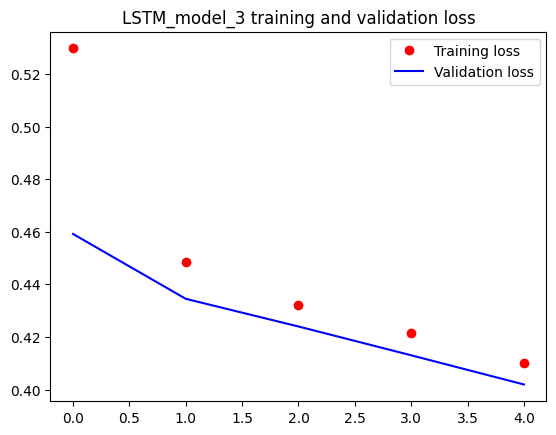

In [62]:
acc = LSTM_model_3_history['accuracy']
val_acc = LSTM_model_3_history['val_accuracy']
loss = LSTM_model_3_history['loss']
val_loss = LSTM_model_3_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('LSTM_model_3 training and validation loss')
plt.legend()

plt.show()

# Q1b - 6 marks: Evaluate the trained LSTM models

The second part of your investigation is to evaluate the models you have trained in Q1a with the test dataset and compare the results.

* Evaluate the trained models on the test dataset in term of accuracy (3 marks)
* Compare the results of different models (3 marks)

## Evaluate the trained models on the test data

In [64]:
LSTM_model_1_model_results = LSTM_model_1.evaluate(test_data, return_dict=True)
LSTM_model_1_model_results

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.7976 - loss: 0.4345


{'accuracy': 0.7981812357902527, 'loss': 0.4326514005661011}

In [65]:
LSTM_model_2_model_results = LSTM_model_2.evaluate(test_data, return_dict=True)
LSTM_model_2_model_results

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.7985 - loss: 0.4298


{'accuracy': 0.7984874844551086, 'loss': 0.42896518111228943}

In [66]:
LSTM_model_3_model_results = LSTM_model_3.evaluate(test_data, return_dict=True)
LSTM_model_3_model_results

625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.8140 - loss: 0.4060


{'accuracy': 0.8140812516212463, 'loss': 0.40574145317077637}

## Compare and comment on the results

Impact of Vocabulary Size:

Comparing LSTM_model_1 (200-word encoder) and LSTM_model_2 (300-word encoder), both with the same embedding length of 16, the test accuracy is nearly identical (0.7981 vs. 0.7984). This suggests that increasing the vocabulary size from 200 to 300 words did not significantly impact the model's performance in this case.

Impact of Embedding Length:

Comparing LSTM_model_2 (embedding length of 16) and LSTM_model_3 (embedding length of 32), both with a 300-word encoder, the test accuracy increased from 0.7984 to 0.8140. This indicates that increasing the embedding length from 16 to 32 improved the model's ability to capture more nuanced relationships in the data, leading to better performance.

Overall Performance:

LSTM_model_3 achieved the highest test accuracy (0.8140), suggesting that the combination of a larger vocabulary size (300 words) and a longer embedding length (32) was the most effective configuration among the three models.

# Q1c - 18 marks: Create, train and evaluate your own LSTM models

The third part of investigation is to design, train and test *two* extended LSTM models that can further improve the test accuracy of *LSTM_model_3* in Q1b. Your choice of different hyper-parameters, such as the number of LSTM units, vocab size and word embedding length, should be justified and verified by the results. You may test as many as possible model designs but you just need to include two best performing ones in your solution. 

* Create your extended models. Each model should achieve a better test accuracy than *LSTM_model_3* and involve adjusting one or more of the aforementioned hyper-parameters from *LSTM_model_3*.  (6 marks)
* Train your extended models, print a summary of each model's structure and parameters, and produce the training/validation graphs. (4 marks)
* Test your models on the test dataset and report their accuracies. (2 marks)
* Compare the results of your models against *LSTM_model_3*, and discuss how these hyper-parameters influence the model performance. (6 marks)

For your models you should:

* use 10% of the training data
* train for 5 epochs, using binary_crossentropy as loss, adam as optimizer, and acuracy as metric.


## Build and train your extended LSTM models 

### Extended_LSTM_Model_1


In [67]:
EMBEDDING_LEN = 32  # The length of the word embedding vector
Extended_LSTM_Model_1 = Sequential([
    encoder300, # using 300-word encoder
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    LSTM(8), # using 8 LSTM units
    Dense(1, activation='sigmoid') # dense layer with 1 node and a sigmoid activation
])

In [69]:
# Compile the model
Extended_LSTM_Model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model with 10% of the training data for 5 epochs
Extended_LSTM_Model_1_history = Extended_LSTM_Model_1.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1)

# Save the model and training records
Extended_LSTM_Model_1.save('Extended_LSTM_Model_1_review.keras')
with open('Extended_LSTM_Model_1_review_history.json', 'w') as f:
    json.dump(Extended_LSTM_Model_1_history.history, f)
    

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 224s 314ms/step - accuracy: 0.7170 - loss: 0.5482 - val_accuracy: 0.7880 - val_loss: 0.4437
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 221s 314ms/step - accuracy: 0.7935 - loss: 0.4393 - val_accuracy: 0.8052 - val_loss: 0.4166
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 222s 315ms/step - accuracy: 0.8074 - loss: 0.4159 - val_accuracy: 0.8181 - val_loss: 0.3961
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 222s 315ms/step - accuracy: 0.8227 - loss: 0.3914 - val_accuracy: 0.8283 - val_loss: 0.3786
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 222s 315ms/step - accuracy: 0.8315 - loss: 0.3753 - val_accuracy: 0.8310 - val_loss: 0.3725


In [70]:
Extended_LSTM_Model_1 = tf.keras.models.load_model('Extended_LSTM_Model_1_review.keras')
with open('Extended_LSTM_Model_1_review_history.json') as f:
    Extended_LSTM_Model_1_history = json.load(f)
    
Extended_LSTM_Model_1.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_5            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, None, 32)       │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 8)              │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,765 (127.99 KB)

 Trainable params: 10,921 (42.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,844 (85.33 KB)

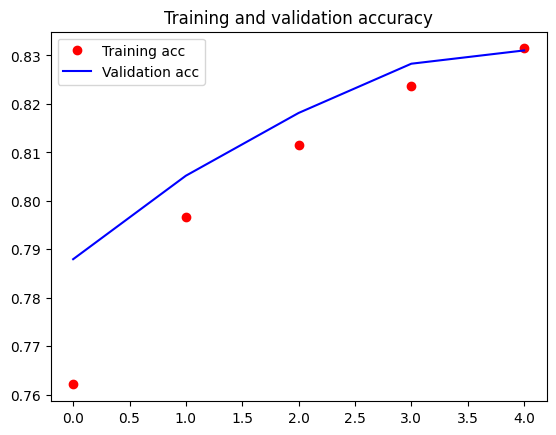

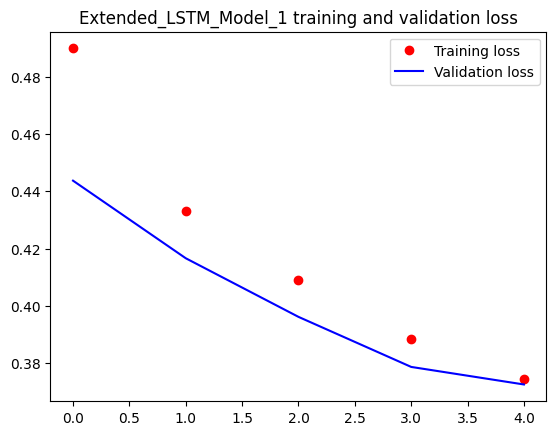

In [71]:
acc = Extended_LSTM_Model_1_history['accuracy']
val_acc = Extended_LSTM_Model_1_history['val_accuracy']
loss = Extended_LSTM_Model_1_history['loss']
val_loss = Extended_LSTM_Model_1_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Extended_LSTM_Model_1 training and validation loss')
plt.legend()

plt.show()

### Extended_LSTM_Model_2

In [75]:
EMBEDDING_LEN = 64  # The length of the word embedding vector
Extended_LSTM_Model_2 = Sequential([
    encoder300, # using 300-word encoder
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    LSTM(4), # using 4 LSTM units
    Dense(1, activation='sigmoid') # dense layer with 1 node and a sigmoid activation
])

In [76]:
# Compile the model
Extended_LSTM_Model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model with 10% of the training data for 5 epochs
Extended_LSTM_Model_2_history = Extended_LSTM_Model_2.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1)

# Save the model and training records
Extended_LSTM_Model_2.save('Extended_LSTM_Model_2_review.keras')
with open('Extended_LSTM_Model_2_review_history.json', 'w') as f:
    json.dump(Extended_LSTM_Model_2_history.history, f)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 223s 313ms/step - accuracy: 0.6972 - loss: 0.5780 - val_accuracy: 0.7911 - val_loss: 0.4466
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 221s 313ms/step - accuracy: 0.8003 - loss: 0.4339 - val_accuracy: 0.8130 - val_loss: 0.4066
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 221s 313ms/step - accuracy: 0.8176 - loss: 0.4021 - val_accuracy: 0.8220 - val_loss: 0.3928
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 221s 314ms/step - accuracy: 0.8241 - loss: 0.3891 - val_accuracy: 0.8230 - val_loss: 0.3859
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 221s 314ms/step - accuracy: 0.8267 - loss: 0.3827 - val_accuracy: 0.8276 - val_loss: 0.3799


In [79]:
Extended_LSTM_Model_2 = tf.keras.models.load_model('Extended_LSTM_Model_2_review.keras')
with open('Extended_LSTM_Model_2_review_history.json') as f:
    Extended_LSTM_Model_2_history = json.load(f)
    
Extended_LSTM_Model_2.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_5            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_10 (Embedding)        │ (None, None, 64)       │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 4)              │         1,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,929 (238.01 KB)

 Trainable params: 20,309 (79.33 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,620 (158.68 KB)

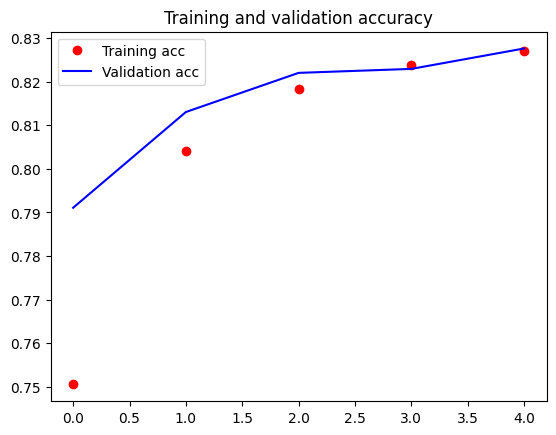

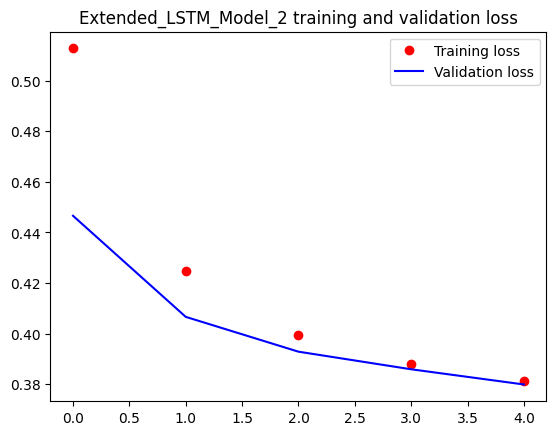

In [80]:
acc = Extended_LSTM_Model_2_history['accuracy']
val_acc = Extended_LSTM_Model_2_history['val_accuracy']
loss = Extended_LSTM_Model_2_history['loss']
val_loss = Extended_LSTM_Model_2_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Extended_LSTM_Model_2 training and validation loss')
plt.legend()

plt.show()

## Evaluate the trained models on the test data

In [74]:
Extended_LSTM_Model_1_results = Extended_LSTM_Model_1.evaluate(test_data, return_dict=True)
Extended_LSTM_Model_1_results

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.8317 - loss: 0.3753


{'accuracy': 0.8318250179290771, 'loss': 0.3749857544898987}

In [81]:
Extended_LSTM_Model_2_results = Extended_LSTM_Model_2.evaluate(test_data, return_dict=True)
Extended_LSTM_Model_2_results

625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - accuracy: 0.8282 - loss: 0.3828


{'accuracy': 0.8276781439781189, 'loss': 0.3817439377307892}

## Compare and comment on the results

Number of LSTM Units:

Extended_LSTM_Model_1 increased the number of LSTM units from 4 to 8 while keeping the embedding length the same (32). This resulted in a significant improvement in test accuracy (0.8318 vs. 0.8140).

Increasing the number of LSTM units allows the model to capture more complex patterns in the data. With more units, the model has a greater capacity to learn temporal dependencies, which likely contributed to the improved performance.

Embedding Length:

Extended_LSTM_Model_2 increased the embedding length from 32 to 64 while reducing the number of LSTM units to 4. This also improved the test accuracy (0.8277 vs. 0.8140).

A longer embedding length allows each word to be represented in a higher-dimensional space, capturing more semantic information. This can help the model better distinguish between different words and their contexts, leading to improved performance.

Trade-offs:

Extended_LSTM_Model_1 achieved the highest accuracy (0.8318), suggesting that increasing the number of LSTM units had a more significant impact on performance than increasing the embedding length in this case.

However, Extended_LSTM_Model_2 also performed well (0.8277), demonstrating that increasing the embedding length can be an effective strategy, especially when computational resources or model complexity need to be managed.

Graphs:

Since both accuracy and loss are still improving (steadily increasing/decreasing), it suggests that the models have not yet fully converged. Training for more epochs could lead to further improvements in performance.

The intersection of training and validation accuracy/loss curves also suggests that the models are generalizing well. This is a positive sign, as it indicates that the models are not overfitting to the training data.

There appear to be no stark differences from the graphs for the performance between both models.